In [1]:
# Section 1 - Imports
# -------------------

# imports
import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join
import copy

# DSO modules
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec, to_attoseconds
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

In [2]:
# Section 2.1 – Define Files needed for analysis
# -----------------------------------------------
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "ja3rx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
dsp3 = join(data_path, "ssaja320.b23359.e24003.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

In [3]:
# Section 2.2 - Load Orbit Data + Initialize Interpolator
# -------------------------------------------------------
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
sat_id = list(intrp._interpolators.keys())[0]

In [4]:
# Section 2.3 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
# ------------------------------------------------------------------------

rnx = DorisRinex(drinex)

site_name = 'DIOB'
result = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True, dpod_freq_corr)
rsta = np.array([result[site_name]['X'], result[site_name]['Y'], result[site_name]['Z']])

# we are also going to need the geodetic coordinates of the site
lat, lon, hgt = transformations.car2ell(*rsta)

In [5]:
# Section 2.4 - Initialize VMF3 from (DORIS) site data
# ----------------------------------------------------
vmf = SiteVmf3(vmf3_data, [site_name])

In [6]:
# Section 2.4 – Preprocess Doppler observations at Iono-Free LC
# -----------------------------------------------------------

##
## https://ids-doris.org/documents/report/ids_workshop_2012/IDS12_s2_Tourain_DORISforIono.pdf
##

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# Nominal frequency for "Ionosphere-Free" linear combination
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma

# store results here
iono = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
    
                # Phase measurements at 2GHz and 400Mhz carriers
                L2ghz   = data['L1']['value']
                L400mhz = data['L2']['value']
                P2ghz   = data['C1']['value']
                P400mhz = data['C2']['value']
                # combine to an "iono-free" (virtual) phase measurement
                L0 = (gamma * P2ghz - P400mhz) / (gamma-1.)
                diono = (P2ghz - L0) - (P400mhz - P2ghz) / (gamma-1.)
    
                # store results
                iono.append(diono*C/s1)
                epochs.append(tai)
                elevations.append(el)

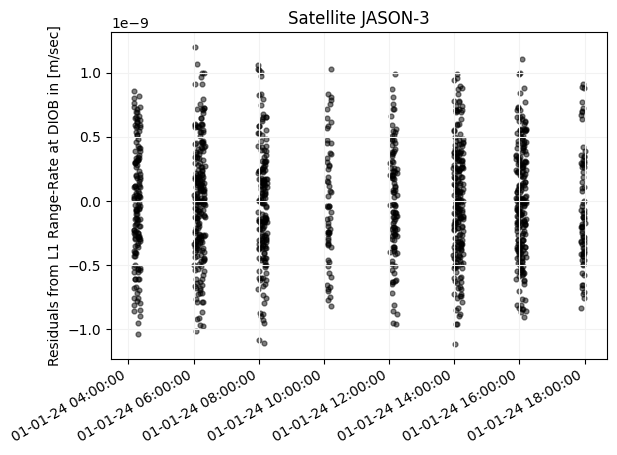

In [7]:
# Section 2.1-1 - Residual plot vs Time

plt.scatter([at2pt(ti) for ti in epochs], iono, alpha=0.5, s=12, c='black')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

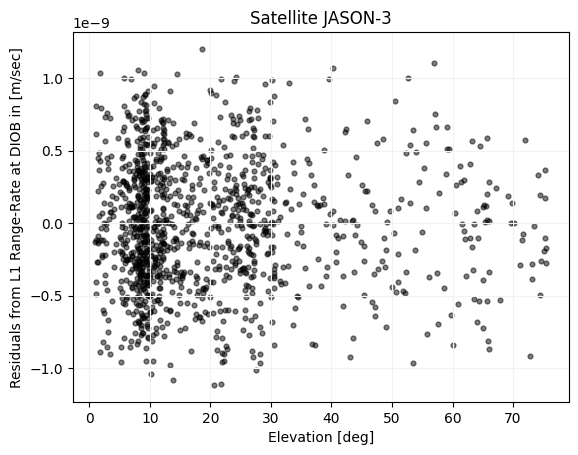

In [8]:
plt.scatter([np.degrees(el) for el in elevations], iono, alpha=0.5, s=12, c='black')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
plt.show()

In [9]:
# Section 2.4 – Preprocess Doppler observations at Iono-Free LC
# -----------------------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(5.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

#
S = 40.3e16*((1.0/u2**2) - (1.0/s1**2)) # ≈ 2.405886538  [m/TECU]
invS = 1.0/S

# 
def Llg(L2ghz, L4mhz):
    l2ghz = C / s1
    l4mhz = C / u2
    return l2ghz*L2ghz - l4mhz*L4mhz

# First iteration
emax = {}
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon != rnx.name2id(site_name):
            continue
        tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
        # see if we have a new pass
        if tai_prev is None or (tai-tai_prev).total_seconds() > 10.:
            pass_nr += 1
            emax[pass_nr] = {'tai': None, 'el':-999., }
        # Satellite position at signal reception time; store into an array
        satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
        rsat = np.array([satx, saty, satz])
        # compute elevation
        _, _, el = transformations.azele(rsat, rsta)
        if el < ELEV_MIN:
            continue
        #
        if el>emax[pass_nr]['el']:
            emax[pass_nr]['tai'] = tai
            emax[pass_nr]['el']  = el
            emax[pass_nr]['Dd']  = -(0.168 + 0.487) * np.sin(el)
            emax[pass_nr]['Dl']  = Llg(data['L1']['value'], data['L2']['value'])
        tai_prev = tai

print(emax)

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
tai_prev = None     # time of last observation if any [TAI]
pass_nr = 0         # current pass index
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 10.:
                pass_nr += 1
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # Delta D, according to
            # https://www.sciencedirect.com/science/article/pii/S027311772300090X?via%3Dihub
            Dd = -(0.168 + 0.487) * np.sin(el)

            # only consider the observation if above cut-off angle
            #if el >= CUTOFF_ANGLE:
    
            # store results
            dL = Llg(data['L1']['value'], data['L2']['value'])
            dstec = -invS * ((dL - emax[pass_nr]['Dl']) - (Dd - emax[pass_nr]['Dd']))
            residuals.append(dstec)
            epochs.append(tai)
            elevations.append(el)

            # prepare for next measurement
            tai_prev    = tai
                    
print("Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel")
print("-------------------------------------------------------------")
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"dSTEC at {site_name} [TECU]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
plt.show()

print(residuals)

NameError: name 'ELEV_MIN' is not defined

In [10]:
plt.scatter([at2pt(ti) for ti in epochs], residuals, alpha=0.2, s=12, c='red')
plt.plot([at2pt(ti) for ti in epochs], residuals, c='blue')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()

NameError: name 'residuals' is not defined

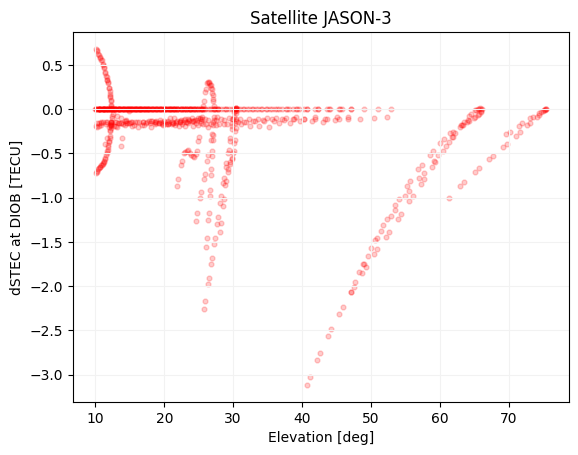

In [18]:
S = 40.3e16*((1.0/u2**2) - (1.0/s1**2))  # m/TECU (positive)
invS = 1.0/S

SAMPLE_GAP_MAX = 10.   # s, safer than 10s
ELEV_MIN = np.radians(10.)

def geometry_free_m(L1_cycles, L2_cycles):
    return (C/s1)*L1_cycles - (C/u2)*L2_cycles

def deltaD(u_hat): ## , dPCO_leo, dPCO_bcn):
    # if you don't have PCO vectors yet, return 0.0 temporarily
    dPCO_bcn = np.array([0e0, 0e0, 0.487])
    dPCO_leo = np.array([0e0, 0e0, (0.555-0.9235)])
    return float(u_hat.dot(dPCO_leo - dPCO_bcn))

def is_slip(Lgf_prev, Lgf_curr, dt):
    # change in geometry-free phase too large for ionosphere in dt
    return abs(Lgf_curr - Lgf_prev) > 5e-1   # meters (tune: 0.5–2 m)

arcs = [] # list of arcs, each arc is list of per-epoch dicts
arc = []

prev_t = None
prev_Lgf = None

for block in rnx:
    for beacon, data in block:
        if beacon != rnx.name2id(site_name):
            continue

        t = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
        satx, saty, satz, _ = intrp.sat_at(sat_id, t)
        rsat = np.array([satx, saty, satz])
        _, _, el = transformations.azele(rsat, rsta)
        if el < ELEV_MIN:
            continue

        Lgf = geometry_free_m(data['L1']['value'], data['L2']['value'])

        # LOS unit (beacon -> LEO). If you don't have beacon ECEF, use your existing routine.
        u = (rsat - rsta) / np.linalg.norm(rsat - rsta)
        # Dd = 0.0  # placeholder until PCO vectors are wired (see deltaD() above)
        Dd = deltaD(u)

        new_arc = False
        if prev_t is None:
            new_arc = True
        else:
            dt = (t - prev_t).total_seconds()
            if dt > SAMPLE_GAP_MAX or (prev_Lgf is not None and is_slip(prev_Lgf, Lgf, dt)):
                new_arc = True

        if new_arc:
            if arc:
                arcs.append(arc)
            arc = []

        arc.append({"t": t, "el": el, "Lgf": Lgf, "Dd": Dd, "rsat": rsat})
        prev_t = t
        prev_Lgf = Lgf

# push last arc
if arc:
    arcs.append(arc)

residuals = []; epochs = []; elevations = [];
# compute dSTEC per arc (all self-referenced to that arc's Emax)
all_dstec = []
for arc in arcs:
    # find epoch of max elevation inside this arc
    k = int(np.argmax([pt["el"] for pt in arc]))
    Lgf_ref = arc[k]["Lgf"]; 
    Dd_ref  = arc[k]["Dd"]

    for pt in arc:
        dL = (pt["Lgf"] - Lgf_ref) - (pt["Dd"] - Dd_ref)
        dstec = -invS * dL   # TECU
        if abs(dstec) < 50.:
            all_dstec.append(dstec)
            epochs.append(pt["t"])
            elevations.append(pt["el"])

# optional sanity filter for gross outliers (still indicates a wrong arc)
# residuals = [x for x in all_dstec if abs(x) < 50.0]  # TECU

plt.scatter([np.degrees(el) for el in elevations], all_dstec, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"dSTEC at {site_name} [TECU]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
plt.show()

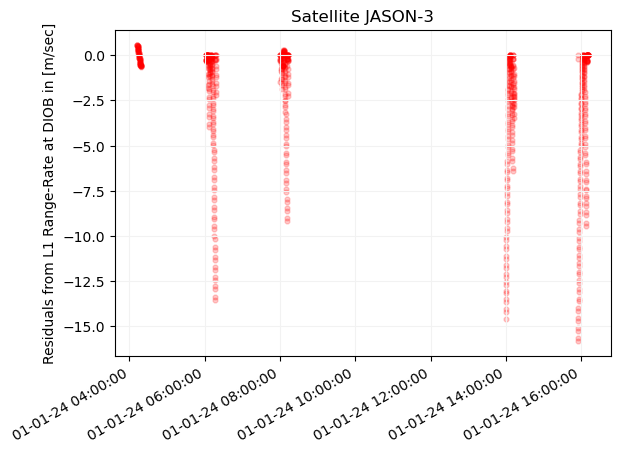

In [42]:
plt.scatter([at2pt(ti) for ti in epochs], all_dstec, alpha=0.2, s=12, c='red')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()